In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
# ============================
# 1. 生成多特征合成数据集
# ============================
np.random.seed(0)
n_samples = 200
n_features = 5    # 多维特征
n_classes = 3

In [3]:
# 为每个类别生成中心点
centers = np.random.uniform(-5, 5, size=(n_classes, n_features))

In [4]:
# 生成样本
X_list = []
y_list = []
for idx, center in enumerate(centers):
    Xi = np.random.randn(n_samples, n_features) * 0.8 + center
    X_list.append(Xi)
    y_list.append(np.full(n_samples, idx))

In [5]:
# 合并数据和标签
X = np.vstack(X_list)
y = np.concatenate(y_list)

In [7]:
X.shape

(600, 5)

In [8]:
y.shape

(600,)

In [9]:
# 拆分训练/测试集
shuffle_idx = np.random.permutation(len(y))
train_size = int(0.7 * len(y))
idx_train = shuffle_idx[:train_size]
idx_test = shuffle_idx[train_size:]
X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test], y[idx_test]

In [10]:
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 420, Test samples: 180


In [11]:
# ============================
# 2. 实现 KNN 算法
# ============================
def knn_predict(X_train, y_train, X_test, k=5, p=2):
    n_test = X_test.shape[0]
    y_pred = np.empty(n_test, dtype=int)
    for i in range(n_test):
        dist = np.linalg.norm(X_train - X_test[i], ord=p, axis=1)
        nn_idx = np.argsort(dist)[:k]
        votes = y_train[nn_idx]
        labels, counts = np.unique(votes, return_counts=True)
        y_pred[i] = labels[np.argmax(counts)]
    return y_pred

In [12]:
# 训练集预测与准确率
y_train_pred = knn_predict(X_train, y_train, X_train, k=5)
train_acc = np.mean(y_train_pred == y_train)
print(f"Train Accuracy: {train_acc:.3f}")

Train Accuracy: 1.000


In [13]:
# 测试集预测与准确率
y_test_pred = knn_predict(X_train, y_train, X_test, k=5)
test_acc = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 1.000


In [14]:
# =======================================
# 3. PCA 可视化（降到 2 维）
# =======================================
# 手动实现 PCA
X_mean = X_train.mean(axis=0)
X_centered = X_train - X_mean
cov = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)
# 取最大的两个特征向量
top2 = eigvecs[:, np.argsort(eigvals)[-2:]]

In [15]:
top2.shape

(5, 2)

In [16]:
# 对训练和测试数据投影到前两主成分
X_train_pca = (X_train - X_mean) @ top2
X_test_pca = (X_test - X_mean) @ top2

In [17]:
X_train_pca.shape

(420, 2)

In [18]:
X_test_pca.shape

(180, 2)

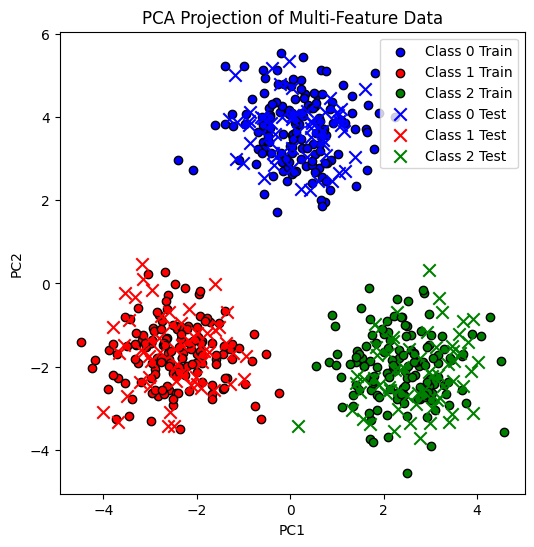

In [19]:
# 绘制投影散点
plt.figure(figsize=(6,6))
colors = ['blue', 'red', 'green']
cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
for cls in range(n_classes):
    plt.scatter(X_train_pca[y_train==cls,0], X_train_pca[y_train==cls,1],
                c=colors[cls], edgecolor='k', label=f'Class {cls} Train')
# 测试点
for cls in range(n_classes):
    plt.scatter(X_test_pca[y_test==cls,0], X_test_pca[y_test==cls,1],
                marker='x', s=80, c=colors[cls], label=f'Class {cls} Test')
plt.title('PCA Projection of Multi-Feature Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [20]:
# =======================================
# 4. 决策边界在 PCA 空间的可视化
# =======================================
# 构建网格
h = 0.1
xx_min, xx_max = X_train_pca[:,0].min() - 1, X_train_pca[:,0].max() + 1
yy_min, yy_max = X_train_pca[:,1].min() - 1, X_train_pca[:,1].max() + 1
xxg, yyg = np.meshgrid(np.arange(xx_min, xx_max, h), np.arange(yy_min, yy_max, h))
# 网格点逆向映射到原特征空间
grid_pca = np.c_[xxg.ravel(), yyg.ravel()]
grid_orig = grid_pca @ top2.T + X_mean

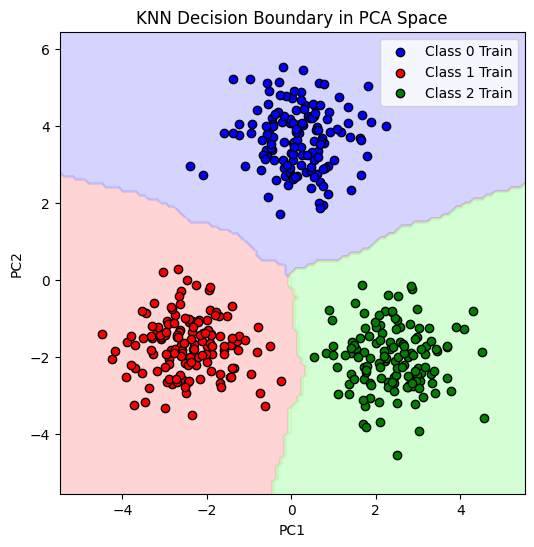

In [ ]:
# 预测
Z = knn_predict(X_train, y_train, grid_orig, k=5)
Z = Z.reshape(xxg.shape)

plt.figure(figsize=(6,6))
plt.contourf(xxg, yyg, Z, cmap=cmap_light, alpha=0.5)
# 重绘训练点
for cls in range(n_classes):
    plt.scatter(X_train_pca[y_train==cls,0], X_train_pca[y_train==cls,1],
                c=colors[cls], edgecolor='k', label=f'Class {cls} Train')
plt.title('KNN Decision Boundary in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
